<a href="https://colab.research.google.com/github/marziehamiri/Facial-expressions-/blob/main/micro_expression_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as tt

In [2]:
!kaggle datasets download -d kmirfan/micro-expressions


Dataset URL: https://www.kaggle.com/datasets/kmirfan/micro-expressions
License(s): unknown
 97% 35.0M/36.3M [00:00<00:00, 104MB/s] 
100% 36.3M/36.3M [00:00<00:00, 88.9MB/s]


In [3]:
!unzip micro-expressions


Streaming output truncated to the last 5000 lines.
  inflating: Micro_Expressions/train/happiness/happiness1041.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1042.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1043.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1044.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1045.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1046.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1047.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1048.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1049.jpg  
  inflating: Micro_Expressions/train/happiness/happiness105.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1050.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1051.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1052.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1053.jpg  
  inflating:

In [4]:
# Classes
datasetDir = "/content/Micro_Expressions"
classes = os.listdir(datasetDir + "/train")
print("Expression Labels: ",classes)

Expression Labels:  ['fear', 'happiness', 'anger', 'neutral', 'sadness', 'disgust', 'surprise']


In [5]:
# data augmentation
tfmsOther = tt.Compose([tt.RandomCrop(80, padding=15, padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor()])
tfmsOtherBlur = tt.Compose([tt.RandomCrop(80, padding=15, padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),tt.GaussianBlur(kernel_size=3, sigma=10),
                        tt.ToTensor()])
tfmsBlur = tt.Compose([tt.GaussianBlur(kernel_size=3, sigma=10),tt.ToTensor()])
tfmsRotate = tt.Compose([tt.RandomRotation(degrees=(-45, 45)),tt.ToTensor()])
tfmsRotateBlur = tt.Compose([tt.GaussianBlur(kernel_size=3, sigma=10),tt.RandomRotation(degrees=(-45, 45)),tt.ToTensor()])
#Loading the dataset as pyTorch Tensors
dataset1 = ImageFolder(datasetDir+"/train",transform=ToTensor()) #original
dataset2 = ImageFolder(datasetDir+"/train",tfmsBlur) #original blur
dataset3 = ImageFolder(datasetDir+"/train",tfmsRotate) #rotated
dataset4 = ImageFolder(datasetDir+"/train",tfmsRotateBlur) #rotated blurred
dataset5 = ImageFolder(datasetDir+"/train",tfmsOther) #other augments
dataset6 = ImageFolder(datasetDir+"/train",tfmsOtherBlur) #other augments blurred
#Combining normal and augmented datasets
dataset = dataset1+dataset2+dataset3+dataset4+dataset5+dataset6
dataset.classes = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

In [6]:
# visualising dataset
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def show_image(image, label):
    print("Label: ",dataset.classes[label])
    plt.imshow(image.permute(1,2,0)) #rgb channel at last in matplot (1st in PyTorch Tensor)

Label:  anger


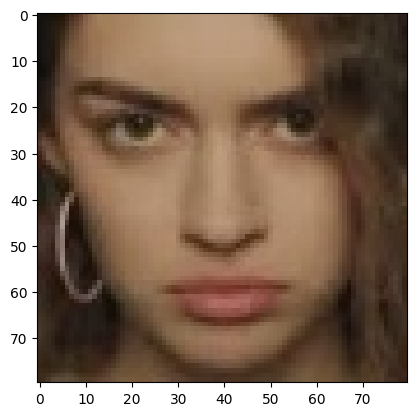

In [7]:
# an example from the dataset
show_image(*dataset[200])

In [8]:
# Splitting dataset into training and validataion set using random_split
randomSeed = 3 #to always create same validation set
torch.manual_seed(randomSeed)
# valSize = 5000
valSize = 2000
trainSize = len(dataset)-valSize
trainDS, valDS = random_split(dataset,[trainSize,valSize])
print("No. of training data: ",len(trainDS))
print("No. of validation data: ",len(valDS))

No. of training data:  43600
No. of validation data:  2000


In [9]:
#Creating data loaders
from torch.utils.data.dataloader import DataLoader
batchSize = 200
trainDL = DataLoader(trainDS,batchSize,shuffle=True,num_workers=4, pin_memory=True)
valDL = DataLoader(valDS,batchSize*2,num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
# Visualizing Batch data
from torchvision.utils import make_grid

def showBatch(DL):
    for images, labels in DL:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([]) #blank label axes
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break

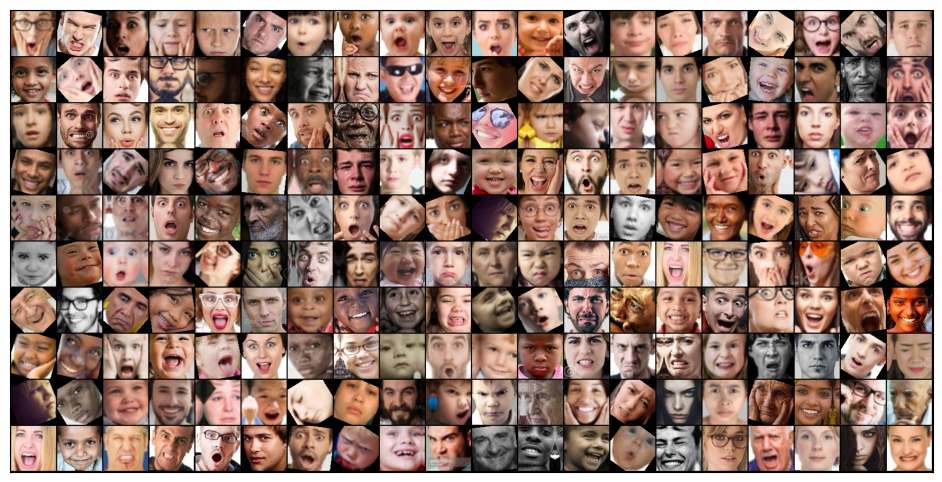

In [11]:
showBatch(trainDL)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
# Some Useful Functions
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images) # predictions
        loss = F.cross_entropy(out, labels) # loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels) # accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs): # for epoch validation loss and accuracy
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean() # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {} , train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
# CNN Model
class MERCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 40 x 40

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 20 x 20

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 10 x 10

            nn.Flatten(),
            nn.Linear(256*10*10, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

In [15]:
# Model structure
model = MERCnnModel()
print(model)

MERCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=25600, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feature

In [16]:
# to select GPU if available or else CPU
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# to move tensor to selected device
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# to wrap a dataloader to move data to the device
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self): # batch of data
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self): # no. of batches
        return len(self.dl)

In [17]:
device = get_default_device()
print("Selected device:",device)

Selected device: cuda


In [18]:
# Wrapping training and validation dataloader
train_dl = DeviceDataLoader(trainDL, device)
val_dl = DeviceDataLoader(valDL, device)
to_device(model, device);

In [19]:
@torch.no_grad() # do not track gradient
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
model = to_device(MERCnnModel(), device)
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 0 , train_loss: 1.7612, val_loss: 1.5451, val_acc: 0.4320
Epoch 1 , train_loss: 1.3074, val_loss: 1.1110, val_acc: 0.6005
Epoch 2 , train_loss: 0.9455, val_loss: 0.8509, val_acc: 0.6995
Epoch 3 , train_loss: 0.7060, val_loss: 0.6687, val_acc: 0.7680
Epoch 4 , train_loss: 0.5534, val_loss: 0.5907, val_acc: 0.7860
Epoch 5 , train_loss: 0.4730, val_loss: 0.5244, val_acc: 0.8195
Epoch 6 , train_loss: 0.4141, val_loss: 0.4751, val_acc: 0.8400
Epoch 7 , train_loss: 0.3828, val_loss: 0.4467, val_acc: 0.8390
Epoch 8 , train_loss: 0.3449, val_loss: 0.4058, val_acc: 0.8735
Epoch 9 , train_loss: 0.3237, val_loss: 0.4189, val_acc: 0.8595
Epoch 10 , train_loss: 0.3036, val_loss: 0.3657, val_acc: 0.8770
Epoch 11 , train_loss: 0.2785, val_loss: 0.3811, val_acc: 0.8760
Epoch 12 , train_loss: 0.2624, val_loss: 0.3209, val_acc: 0.8930
Epoch 13 , train_loss: 0.2455, val_loss: 0.3580, val_acc: 0.8780
Epoch 14 , train_loss: 0.2413, val_loss: 0.3474, val_acc: 0.8800


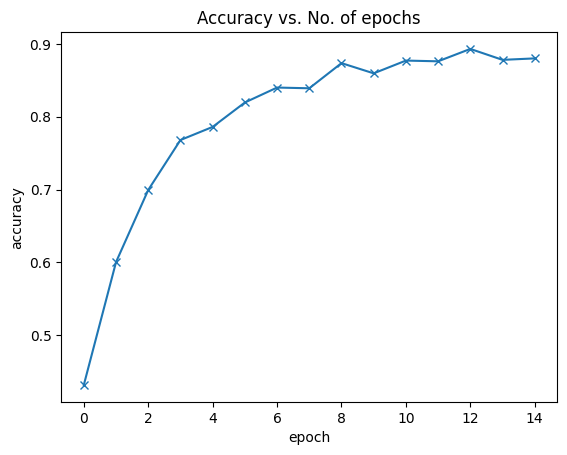

In [21]:
# Validation accuracy
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

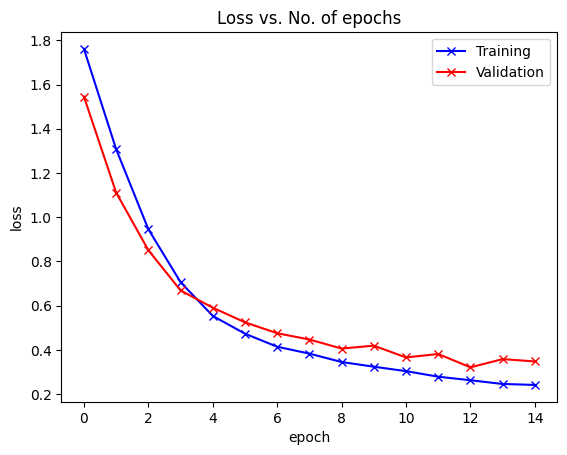

In [22]:
# Training and validation loss
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

In [23]:
# Test set prediction
def predict_image(image, model):
    xb = to_device(image.unsqueeze(0), device) # Convert to a batch of 1
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1) # pick class with highest probability
    return dataset.classes[preds[0].item()] # return class label

Label: anger , Predicted: anger


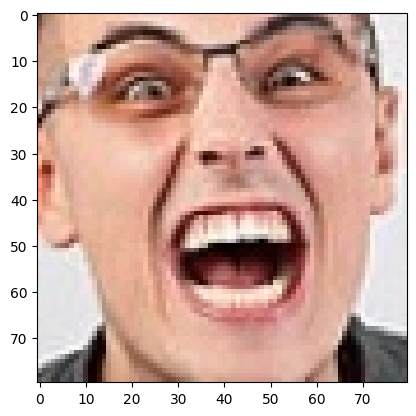

In [27]:
test_dataset = ImageFolder(datasetDir+'/test', transform=ToTensor())
image, label = test_dataset[103]
plt.imshow(image.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(image, model))

In [28]:
# Test set accuracy
test_loader = DeviceDataLoader(DataLoader(test_dataset, batchSize*2), device)
result = evaluate(model, test_loader)
print("test loss:",result['val_loss']) # in evaluate -> validation_step function its named val_loss and val_acc, so renamed here for testset
print("test accuracy:",result['val_acc'])

test loss: 0.8160290122032166
test accuracy: 0.8148077130317688


In [29]:
torch.save(model.state_dict(),'MERCnn.pth')

In [32]:
modelSaved = to_device(MERCnnModel(),device)
# modelSaved.load_state_dict(torch.load('MERCnn.pth'))